In [70]:
import numpy as np
import matplotlib.pyplot as plt
from pgmpy.factors.discrete import State
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination
from pgmpy.sampling import BayesianModelSampling

# Defining the network structure
covid_model = BayesianModel([('Contact', 'Covid'), ('Mask', 'Covid'), ('Covid','Fever'), ('Covid', 'Dry_cough'), ('Covid', 'Death')])

# Contact = Person of interest has being in the same room with a person having Covid-19.
# Mask = The person wears a mask when gets out from home.
# Covid = The person has the Covid-19.
# Fever = The person has the fever.
# Dry_cough = The person has the cough.
# Death = The person will die today.

# Defining the CPTs:
cpd_contact = TabularCPD('Contact', 2, [[0.95],[0.05]])
cpd_m = TabularCPD('Mask', 2, [[0.35],[0.65]])
cpd_covid = TabularCPD('Covid', 2, [[1, 1, 0.1, 0.85], [0, 0, 0.9, 0.15]], evidence=['Contact', 'Mask'], evidence_card=[2, 2])
cpd_f = TabularCPD('Fever', 2, [[0.985, 0.12], [0.015, 0.88]], evidence=['Covid'], evidence_card = [2])
cpd_dc = TabularCPD('Dry_cough', 2, [[0.75, 0.33], [0.25, 0.67]], evidence=['Covid'], evidence_card= [2])
cpd_d = TabularCPD('Death', 2, [[0.99825, 0.9981625], [0.00175, 0.0018375]], evidence=['Covid'], evidence_card=[2])

print(cpd_contact)
print(cpd_m)
print(cpd_covid)
print(cpd_f)
print(cpd_dc)
print(cpd_d)


+------------+------+
| Contact(0) | 0.95 |
+------------+------+
| Contact(1) | 0.05 |
+------------+------+
+---------+------+
| Mask(0) | 0.35 |
+---------+------+
| Mask(1) | 0.65 |
+---------+------+
+----------+------------+------------+------------+------------+
| Contact  | Contact(0) | Contact(0) | Contact(1) | Contact(1) |
+----------+------------+------------+------------+------------+
| Mask     | Mask(0)    | Mask(1)    | Mask(0)    | Mask(1)    |
+----------+------------+------------+------------+------------+
| Covid(0) | 1.0        | 1.0        | 0.1        | 0.85       |
+----------+------------+------------+------------+------------+
| Covid(1) | 0.0        | 0.0        | 0.9        | 0.15       |
+----------+------------+------------+------------+------------+
+----------+----------+----------+
| Covid    | Covid(0) | Covid(1) |
+----------+----------+----------+
| Fever(0) | 0.985    | 0.12     |
+----------+----------+----------+
| Fever(1) | 0.015    | 0.88     |


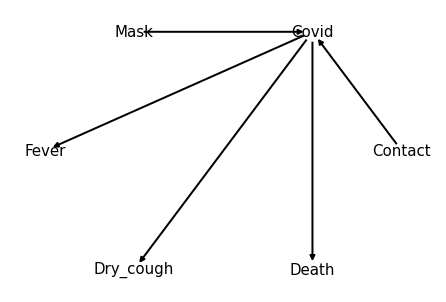

In [71]:
# Associating the CPDs with the network structure.
covid_model.add_cpds(cpd_contact,cpd_covid,cpd_m,cpd_f,cpd_dc,cpd_d)


import networkx as nx
import pylab as plt
nx.draw_kamada_kawai(covid_model, arrowsize=10, with_labels=True, node_color='#ffffff', font_size=15, width =2)
plt.show()

# Flow of probabilistic inference

In [72]:
# command to get all the independencies wrt a variable
covid_model.local_independencies('Fever')

(Fever _|_ Contact, Mask, Dry_cough, Death | Covid)

In [73]:
# In the previous cell we can notice that given Covid, Fever is independent from all the other nodes, so we expect that
# the markov blanket of Fever is made up only by Covid:

# we can't use this command because Fever is a leaf node:
#covid_model.get_markov_blanket('Fever') 

# but we can show the markov blanket using the definition:
print('parents of Fever = ', str(covid_model.get_parents('Fever')))
print('childrens of Fever = ', str(covid_model.get_children('Fever')))
try:
    childrens = covid_model.get_children
    child_par = []
    for children in childrens:
        child_par += covid_model.get_parent(children)
    print('parents of the childrens of Fever = ', str(child_par))
except:
    print('parents of the childrens of Fever = []')


parents of Fever =  ['Covid']
childrens of Fever =  []
parents of the childrens of Fever = []


In [74]:
#  X <- Z -> trail enabled:
print(covid_model.is_active_trail('Fever','Dry_cough')) # Fever and Dry_cough dependent

#  X <- Z -> trail blocked:
print(covid_model.is_active_trail('Fever','Dry_cough', observed=['Covid']))  # Fever and Dry_cough independent


True
False


In [75]:
# V structure not enabled:
print(covid_model.is_active_trail('Mask', 'Contact')) # Mask and Contact are independent

# V structure enabled:
print(covid_model.is_active_trail('Mask', 'Contact', observed=['Covid']))  # Mask and Contact are dependent given Covid

False
True


In [76]:
# command to get all the independencies of all the variables:
# covid_model.get_independencies()

# INFERENCES:

In [77]:
# Instantiate "variable elimination" as an inference method on the model, then query
inference = VariableElimination(covid_model)

# Causal queries (from cause to effect, prediction):

In [78]:
# P(Covid = True |Mask = True)
q1 = inference.query(['Covid'],{'Mask':1})

# P(Covid = True |Mask = False)
q2 = inference.query(['Covid'],{'Mask':0})

print("Chance of having Covid-19 if you always use the mask: {:.3f} %".format(q1.values[1]*100))
print("\nChance of having Covid-19 if you never use the mask: {:.3f} %".format(q2.values[1]*100))
print("\nIn other words if you never use the mask you have {:.0f} times more chances of getting the virus".format(q2.values[1]/q1.values[1]))

Eliminating: Death: 100%|███████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 497.88it/s]

Chance of having Covid-19 if you always use the mask: 0.750 %

Chance of having Covid-19 if you never use the mask: 4.500 %

In other words if you never use the mask you have 6 times more chances of getting the virus


In [79]:
# P(Death = True | Mask = True)
q3 = inference.query(['Death'],{'Mask':1});

# P(Death = True | Mask = False)
q4 = inference.query(['Death'],{'Mask':0});

print("Chance of dying today if you always use the mask: {:.4f} %".format(q3.values[1]*100))
print("\nChance of dying today if you never use the mask: {:.4f} %".format(q4.values[1]*100))
print("\nIn other words if you never use the mask you have {:.4f} times more chances of dying today".format(q4.values[1]/q3.values[1]))

Eliminating: Covid: 100%|███████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 500.01it/s]

Chance of dying today if you always use the mask: 0.1751 %

Chance of dying today if you never use the mask: 0.1754 %

In other words if you never use the mask you have 1.0019 times more chances of dying today


# Evidential queries (from effect to cause, explanation):

In [80]:
# P(Covid = True| Fever = True) 
q5 = inference.query(['Covid'],{'Fever':1});
print("Chance of having Covid-19 given that you have the fever {:.2f} %".format(q5.values[1]*100))

# P(Covid = True| Dry_cough = True)
q6 = inference.query(['Covid'],{'Dry_cough':1});
print("Chance of having Covid-19 given that you have a dry cough {:.2f} %".format(q6.values[1]*100))

# P(Covid = True| Dry_cough = True, Fever = True)
q7 = inference.query(['Covid'],{'Dry_cough':1, 'Fever':1});
print("Chance of having Covid-19 given that you have a dry cough AND the fever {:.2f} %".format(q7.values[1]*100))

Eliminating: Death: 100%|███████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 374.97it/s]

Chance of having Covid-19 given that you have the fever 55.27 %
Chance of having Covid-19 given that you have a dry cough 5.34 %
Chance of having Covid-19 given that you have a dry cough AND the fever 76.80 %


# Approximate sampling methods:

In [81]:
# defining re-adapted functions taken from the notebook made available by Paolo Torroni:

def prob_LW(samples,variable):
    return round(np.sum(np.dot(samples[variable],samples['_weight']))/np.sum(samples['_weight']),2)

def absolute_error(exact_value,approx_value):
    return np.absolute(exact_value-approx_value)

def run_experiment(model, sample_size, query_variable, pquery, evidence, verbose = False):
    
    # model conversion:
    sampling_model = BayesianModelSampling(model)
        
    # Sample
    samples_LW = sampling_model.likelihood_weighted_sample(evidence = evidence, size=sample_size, return_type='recarray')
    samples_RS = sampling_model.rejection_sample(evidence=evidence, size=sample_size, return_type='recarray')

    # Statistics: query probability
    pquery_LW=prob_LW(samples_LW, query_variable)
    pquery_RS=np.recarray.mean(samples_RS[query_variable], axis=0)

    
    # Reporting
    if(verbose):
        print("\nP(Covid=true|Fever=true,Dry_cough=true) =", round(pquery,precision))
        print("With Rejection Sampling after %d samples: %.3f (error = %.2f percent)" 
              % (sample_size, pquery_RS, absolute_error(pquery,pquery_RS)*100))
        print("With Likelihood Weighting after %d samples: %.3f (error = %.2f percent)" 
              % (sample_size, pquery_LW, absolute_error(pquery,pquery_LW)*100))
    
    # Return results
    return np.array([(sample_size, 
                      pquery_RS, absolute_error(pquery,pquery_RS),
                      pquery_LW, absolute_error(pquery,pquery_LW))], 
                    dtype=[('sample_size', '<i8'), 
                           ('pquery_RS', '<f8'),('e_pquery_RS', '<f8'),
                           ('pquery_LW', '<f8'),('e_pquery_LW', '<f8')])

# To view samples
# print(samples_LW)
# samples_LW.view()
# print(samples_RS[:5]), print(' ... '), print(samples_RS[nsamples_RS-5:])

In [82]:
# defining useful functions to test and show results of a query 

def run_all(query_variable, evidence, starting_size_=1, final_size=5, experiments=8): 
    # Use this function only to compute probabilities in which the query_variable is True.
    
    if len(evidence)==5:
        pquery = inference.query([query_variable],{evidence[0][0]:evidence[0][1], evidence[1][0]:evidence[1][1],evidence[2][0]:evidence[2][1],evidence[3][0]:evidence[3][1],evidence[4][0]:evidence[4][1]}).values[1]
        evidence = [State(evidence[0][0],evidence[0][1]),State(evidence[1][0],evidence[1][1]),State(evidence[2][0],evidence[2][1]),State(evidence[3][0],evidence[3][1]),State(evidence[4][0],evidence[4][1])]
        title = 'P( '+query_variable+' = 1 | ' + evidence[0][0] + ' = '+ str(evidence[0][1]) + ', ' + evidence[1][0] + ' = ' + str(evidence[1][1]) + ', '+ evidence[2][0] + ' = ' + str(evidence[2][1]) +', '+ evidence[3][0] + ' = ' + str(evidence[3][1]) +', '+ evidence[4][0] + ' = ' + str(evidence[4][1]) +')'

    
    if len(evidence)==4:
        pquery = inference.query([query_variable],{evidence[0][0]:evidence[0][1], evidence[1][0]:evidence[1][1],evidence[2][0]:evidence[2][1],evidence[3][0]:evidence[3][1]}).values[1]
        evidence = [State(evidence[0][0],evidence[0][1]),State(evidence[1][0],evidence[1][1]),State(evidence[2][0],evidence[2][1]),State(evidence[3][0],evidence[3][1])]
        title = 'P( '+query_variable+' = 1 | ' + evidence[0][0] + ' = '+ str(evidence[0][1]) + ', ' + evidence[1][0] + ' = ' + str(evidence[1][1]) + ', '+ evidence[2][0] + ' = ' + str(evidence[2][1]) +', '+ evidence[3][0] + ' = ' + str(evidence[3][1]) +')'
        
    if len(evidence)==3:
        pquery = inference.query([query_variable],{evidence[0][0]:evidence[0][1], evidence[1][0]:evidence[1][1],evidence[2][0]:evidence[2][1]}).values[1]
        evidence = [State(evidence[0][0],evidence[0][1]),State(evidence[1][0],evidence[1][1]),State(evidence[2][0],evidence[2][1])]
        title = 'P( '+query_variable+' = 1 | ' + evidence[0][0] + ' = '+ str(evidence[0][1]) + ', ' + evidence[1][0] + ' = ' + str(evidence[1][1]) + ', '+ evidence[2][0] + ' = ' + str(evidence[2][1]) + ')'
   
    if len(evidence)==2:
        pquery = inference.query([query_variable],{evidence[0][0]:evidence[0][1], evidence[1][0]:evidence[1][1]}).values[1]
        evidence = [State(evidence[0][0],evidence[0][1]),State(evidence[1][0],evidence[1][1])]
        title = 'P( '+query_variable+' = 1 | ' + evidence[0][0] + ' = '+ str(evidence[0][1]) + ', ' + evidence[1][0] + ' = ' + str(evidence[1][1]) + ')'
    if len(evidence)==1:
        pquery = inference.query([query_variable],{evidence[0][0]:evidence[0][1]}).values[1]
        evidence = [State(evidence[0][0],evidence[0][1])]
        title = 'P( ' + query_variable +' = 1 | ' + evidence[0][0] + ' = ' + str(evidence[0][1]) + ')'
    if len(evidence)==0:
        pquery = inference.query([query_variable]).values[1]
        evidence = []
        title = 'P( '+query_variable+' = 1 )'
    
    results = np.array([],dtype=[('sample_size', '<i8'), 
                             ('pquery_RS', '<f8'),('e_pquery_RS', '<f8'),
                             ('pquery_LW', '<f8'),('e_pquery_LW', '<f8')])

    
    
    for size in np.logspace(starting_size_, final_size, num=experiments, dtype='<i8'):
        results=np.append(results,run_experiment(covid_model, size, query_variable, pquery, evidence, verbose = False))

    
    # save and plot results:
    
    title_file = title.replace(" ","")
    title_file = title_file.replace("=","_") 
    title_file = title_file.replace("(","_") 
    title_file = title_file.replace(")","_") 
    title_file = title_file.replace(",","_") 
    title_file = title_file.replace("|","__") 
 
    with open('results'+title_file+'.npy', 'wb') as f:
            np.save(f,results)
            
def plot_results(query_variable, evidence, ylim_conv, ylim_abs): 
    
    if len(evidence)==4:
        pquery = inference.query([query_variable],{evidence[0][0]:evidence[0][1], evidence[1][0]:evidence[1][1],evidence[2][0]:evidence[2][1],evidence[3][0]:evidence[3][1]}).values[1]
        evidence = [State(evidence[0][0],evidence[0][1]),State(evidence[1][0],evidence[1][1]),State(evidence[2][0],evidence[2][1]),State(evidence[3][0],evidence[3][1])]
        title = 'P( '+query_variable+' = 1 | ' + evidence[0][0] + ' = '+ str(evidence[0][1]) + ', ' + evidence[1][0] + ' = ' + str(evidence[1][1]) + ', '+ evidence[2][0] + ' = ' + str(evidence[2][1]) +', '+ evidence[3][0] + ' = ' + str(evidence[3][1]) +')'
    
    if len(evidence)==3:
        pquery = inference.query([query_variable],{evidence[0][0]:evidence[0][1], evidence[1][0]:evidence[1][1],evidence[2][0]:evidence[2][1]}).values[1]
        evidence = [State(evidence[0][0],evidence[0][1]),State(evidence[1][0],evidence[1][1]),State(evidence[2][0],evidence[2][1])]
        title = 'P( '+query_variable+' = 1 | ' + evidence[0][0] + ' = '+ str(evidence[0][1]) + ', ' + evidence[1][0] + ' = ' + str(evidence[1][1]) + ', '+ evidence[2][0] + ' = ' + str(evidence[2][1]) + ')'
   
    if len(evidence)==2:
        pquery = inference.query([query_variable],{evidence[0][0]:evidence[0][1], evidence[1][0]:evidence[1][1]}).values[1]
        evidence = [State(evidence[0][0],evidence[0][1]),State(evidence[1][0],evidence[1][1])]
        title = 'P( '+query_variable+' = 1 | ' + evidence[0][0] + ' = '+ str(evidence[0][1]) + ', ' + evidence[1][0] + ' = ' + str(evidence[1][1]) + ')'
    if len(evidence)==1:
        pquery = inference.query([query_variable],{evidence[0][0]:evidence[0][1]}).values[1]
        evidence = [State(evidence[0][0],evidence[0][1])]
        title = 'P( ' + query_variable +' = 1 | ' + evidence[0][0] + ' = ' + str(evidence[0][1]) + ')'
    if len(evidence)==0:
        pquery = inference.query([query_variable]).values[1]
        evidence = []
        title = 'P( '+ query_variable +' = 1 )'
    
    results = np.array([],dtype=[('sample_size', '<i8'), 
                             ('pquery_RS', '<f8'),('e_pquery_RS', '<f8'),
                             ('pquery_LW', '<f8'),('e_pquery_LW', '<f8')])

    #print(title + '=' + str(pquery*100))
    
    title_file = title.replace(" ","")
    title_file = title_file.replace("=","_") 
    title_file = title_file.replace("(","_") 
    title_file = title_file.replace(")","_") 
    title_file = title_file.replace(",","_") 
    title_file = title_file.replace("|","__") 
 
    with open('results'+title_file+'.npy', 'rb') as f:
            results = np.load(f)
        
        
    # plot convergence to exact inference value:
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.ylim(ylim_conv[:])
    
    plt.title(title)
    LWCplot, = plt.semilogx(results['sample_size'],results['pquery_LW'],'b',label="Likelihood Weighting")
    RSCplot, = plt.semilogx(results['sample_size'],results['pquery_RS'],'g',label="Rejection Sampling")
    VECplot, = plt.semilogx(results['sample_size'],pquery*np.ones(results.size),'r',label="reference value")
    plt.legend(handles=[LWCplot,RSCplot,VECplot]);
    plt.savefig(title_file+'.png')
            
    # plot absolute error:
    plt.figure(figsize=(20,5))
    plt.subplot(121)
    plt.ylim(ylim_abs[:])
    plt.title('Absolute error on '+ title)
    ELWCplot, = plt.semilogx(results['sample_size'],results['e_pquery_LW'],'b',label="Likelihood Weighting")
    ERSCplot, = plt.semilogx(results['sample_size'],results['e_pquery_RS'],'g',label="Rejection Sampling")
    plt.legend(handles=[ELWCplot,ERSCplot]);
    plt.savefig('abs_err'+title_file+'.png')

In [83]:
# The results discussed in the report are already computed and stored so to see the results of the computation done by this cell
# you can skip directly to the next one.

#query_variableS = ['Covid','Covid','Death','Mask']
#evidenceS = [ [['Fever',1],['Dry_cough',1]] , [['Contact',1],['Mask',1]] , [['Mask',1]], [['Covid',1], ['Contact',1], ['Fever',1], ['Dry_cough',1],['Death',1]] ]

             
#for i in range(len(query_variableS)):
#        run_all(query_variableS[i], evidenceS[i], starting_size_=1, final_size=5, experiments=8)

Eliminating: Death: 100%|███████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 250.06it/s]


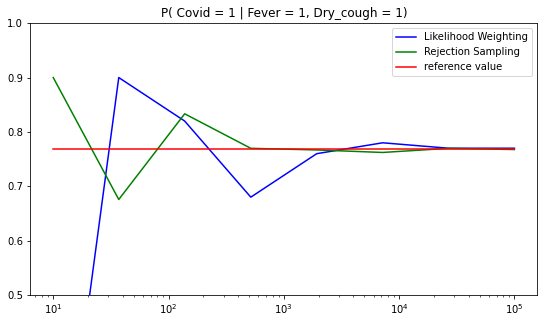

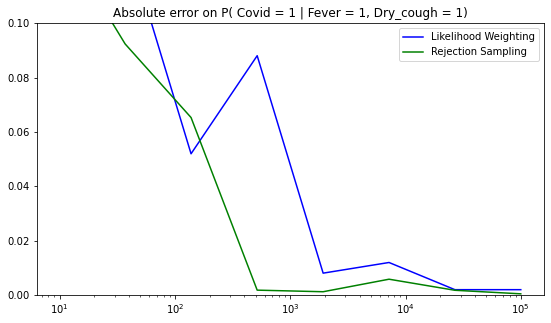

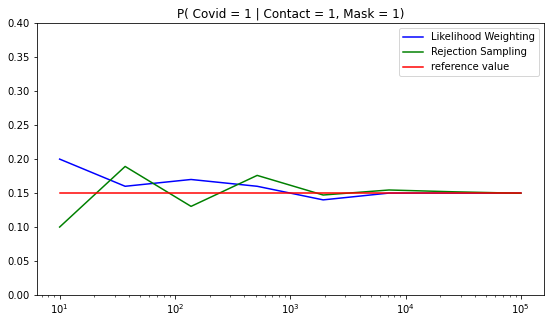

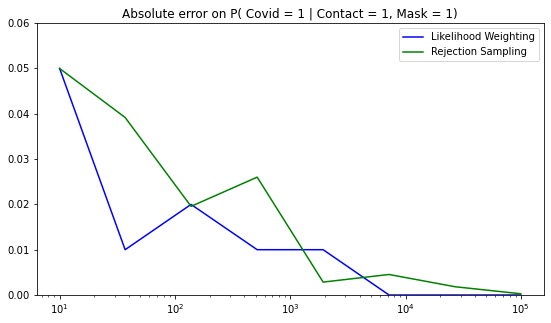

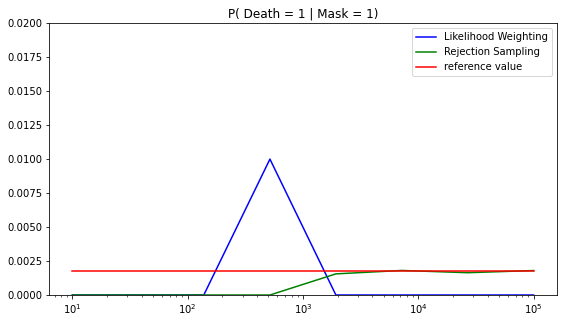

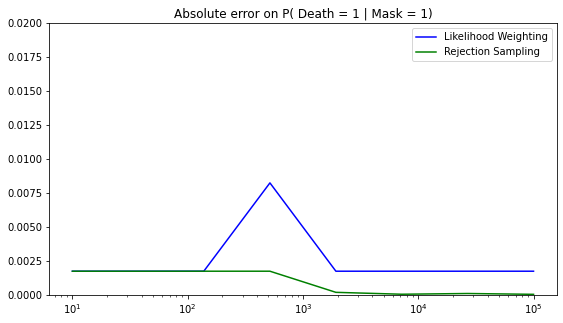

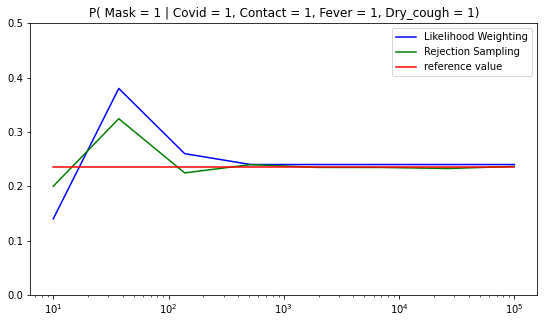

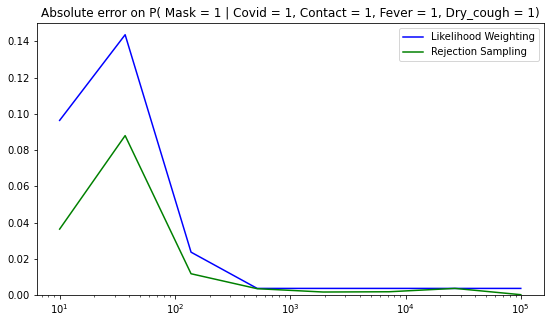

In [84]:
# uncomment the next 4 lines to see the results discussed in the report: 
query_variableS = ['Covid','Covid','Death','Mask']
evidenceS = [ [['Fever',1],['Dry_cough',1]] , [['Contact',1],['Mask',1]] , [['Mask',1]], [['Covid',1], ['Contact',1], ['Fever',1], ['Dry_cough',1]] ]
ylim_conv = [[0.5,1], [0,0.4], [0,0.02],[0,.5]]
ylim_abs = [[0,.1], [0,.06],[0,.02], [0,.15]]

for i in range(len(query_variableS)):
     plot_results(query_variableS[i], evidenceS[i], ylim_conv[i], ylim_abs[i])